In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import onnxruntime as rt
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
import chardet

In [9]:
# constants and parameters definition

data_path = '../data/300k_dataset.csv'
model_1_path = '../model/model_1.onnx'
model_2_path = '../model/model_2.onnx'
image_path = '../images/'
data_description_path = '../data/data_description.csv'

with open(data_description_path, 'rb') as file:
    raw_data = file.read()
    encoding = chardet.detect(raw_data)['encoding']
# read data from data description
data_description = pd.read_csv(data_description_path, encoding=encoding)
# sensitive attributes is elements in 'Feature (nl)' whose 'Relative importance' is not 0
sensitive_attributes = data_description[data_description['Relative importance'] != 0]['Feature (nl)'].values
print(f"length of sensitive_attributes is {len(sensitive_attributes)}")
# sensitive_attributes = ['persoon_leeftijd_bij_onderzoek', 'persoon_geslacht_vrouw','persoonlijke_eigenschappen_spreektaal']
fairness_threshold = 0.05 

length of sensitive_attributes is 252


In [20]:
# functions definition
def metamorphic_testing(model_path, data_address, sensitive_attributes, fairness_threshold=0.05):
    data = pd.read_csv(data_address)
    X = data.drop(['checked', 'Ja', 'Nee'], axis=1)
    X = X.astype(np.float32)

    session = rt.InferenceSession(model_path)
    input_name = session.get_inputs()[0].name

    fairness_violations = {}

    preds_original = session.run(None, {input_name: X.values.astype(np.float32)})[0]

    for attr in sensitive_attributes:
        sensitive_data = data[attr]
        print(f"Testing fairness for attribute: {attr}")
        modified_X = X.copy()
        unique_values = sensitive_data.unique()
        if len(unique_values) < 2:
            print(f"Attribute {attr} has less than two unique values, skipping.")
            continue
        new_value = unique_values[1] if sensitive_data.iloc[0] == unique_values[0] else unique_values[0]
        modified_X[attr] = new_value

        # preds_original should only run once
        # preds_original = session.run(None, {input_name: X.values.astype(np.float32)})[0]
        preds_modified = session.run(None, {input_name: modified_X.values.astype(np.float32)})[0]

        if preds_original.ndim > 1:
            preds_original = np.argmax(preds_original, axis=1)
            preds_modified = np.argmax(preds_modified, axis=1)

        change_mask = preds_original != preds_modified
        change_rate = change_mask.mean()

        if change_rate > fairness_threshold:
            fairness_violations[attr] = {
                "change_rate": change_rate,
                "changed_samples": sensitive_data[change_mask],
                "violation": True
            }
            print(f"Fairness violation detected for {attr}: {change_rate:.2%}")
        else:
            fairness_violations[attr] = {
                "change_rate": change_rate,
                "changed_samples": sensitive_data[change_mask],
                "violation": False
            }
            print(f"No significant fairness violation for {attr} (Change rate: {change_rate:.2%}).")

    return fairness_violations

def visualize_fairness_bar(violations):
    i = 1
    for attr, result in violations.items():
        if not result['violation']:
            continue

        changed_samples = result['changed_samples']
        attr_values = changed_samples.value_counts()

        plt.figure(figsize=(10, 6))
        # sns.set(style="whitegrid")
        # sns.barplot(x=attr_values.index, y=attr_values.values, color = sns.color_palette("husl", 9)[6])
        # sns.barplot(x=attr_values.index, y=attr_values.values)
        # plt.bar(attr_values.index, attr_values.values,color="orange")
        plt.bar(attr_values.index, attr_values.values)
        plt.title(f"Prediction Change Distribution for \'{attr}\'", fontsize=14, fontweight='bold')
        plt.xlabel(f"{attr}", fontsize=14, fontweight='bold')
        plt.ylabel("Count of Prediction Changes", fontsize=14,fontweight='bold')
        plt.xticks(rotation=45, fontsize=14)
        plt.yticks(fontsize=14) 
        plt.tight_layout()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.savefig(f"{image_path}metatest_{i}.png")
        plt.show()
        i += 1

def print_res(violations):
    for attr, result in violations.items():
        if result['violation']:
            print(f"--- Results for {attr} ---")
            print(f"Change rate: {result['change_rate']:.2%}")
            print(f"Fairness violation: {result['violation']}")

In [12]:
# test and visualize

violations = metamorphic_testing(
    model_1_path,
    data_path,
    sensitive_attributes=sensitive_attributes,
    fairness_threshold=fairness_threshold
)
print_res(violations)

Testing fairness for attribute: adres_aantal_brp_adres
No significant fairness violation for adres_aantal_brp_adres (Change rate: 0.00%).
Testing fairness for attribute: adres_aantal_verschillende_wijken
No significant fairness violation for adres_aantal_verschillende_wijken (Change rate: 0.00%).
Testing fairness for attribute: adres_aantal_verzendadres
No significant fairness violation for adres_aantal_verzendadres (Change rate: 0.00%).
Testing fairness for attribute: adres_aantal_woonadres_handmatig
No significant fairness violation for adres_aantal_woonadres_handmatig (Change rate: 0.00%).
Testing fairness for attribute: adres_dagen_op_adres
No significant fairness violation for adres_dagen_op_adres (Change rate: 0.00%).
Testing fairness for attribute: adres_recentst_onderdeel_rdam
No significant fairness violation for adres_recentst_onderdeel_rdam (Change rate: 0.00%).
Testing fairness for attribute: adres_recentste_buurt_groot_ijsselmonde
No significant fairness violation for adre

In [15]:
# test and visualize
violations = metamorphic_testing(
    model_2_path,
    data_path,
    sensitive_attributes=sensitive_attributes,
    fairness_threshold=fairness_threshold
)
print_res(violations)

Testing fairness for attribute: adres_aantal_brp_adres
No significant fairness violation for adres_aantal_brp_adres (Change rate: 0.00%).
Testing fairness for attribute: adres_aantal_verschillende_wijken
No significant fairness violation for adres_aantal_verschillende_wijken (Change rate: 0.00%).
Testing fairness for attribute: adres_aantal_verzendadres
No significant fairness violation for adres_aantal_verzendadres (Change rate: 0.00%).
Testing fairness for attribute: adres_aantal_woonadres_handmatig
No significant fairness violation for adres_aantal_woonadres_handmatig (Change rate: 0.00%).
Testing fairness for attribute: adres_dagen_op_adres
No significant fairness violation for adres_dagen_op_adres (Change rate: 1.95%).
Testing fairness for attribute: adres_recentst_onderdeel_rdam
No significant fairness violation for adres_recentst_onderdeel_rdam (Change rate: 0.00%).
Testing fairness for attribute: adres_recentste_buurt_groot_ijsselmonde
No significant fairness violation for adre

In [16]:
# mapping_dict = data_description.set_index('Feature (nl)')['Feature (en)'].to_dict()
for attr, result in violations.items():
    if result['violation'] == True:
        # attr_en = mapping_dict[attr]
        print(f"{attr} change rate is {result['change_rate']:.2%}")

competentie_vakdeskundigheid_toepassen change rate is 7.07%
contacten_soort_afgelopenjaar_document__uitgaand_ change rate is 6.19%
persoon_leeftijd_bij_onderzoek change rate is 5.30%
persoonlijke_eigenschappen_dagen_sinds_taaleis change rate is 10.63%
relatie_kind_huidige_aantal change rate is 8.77%


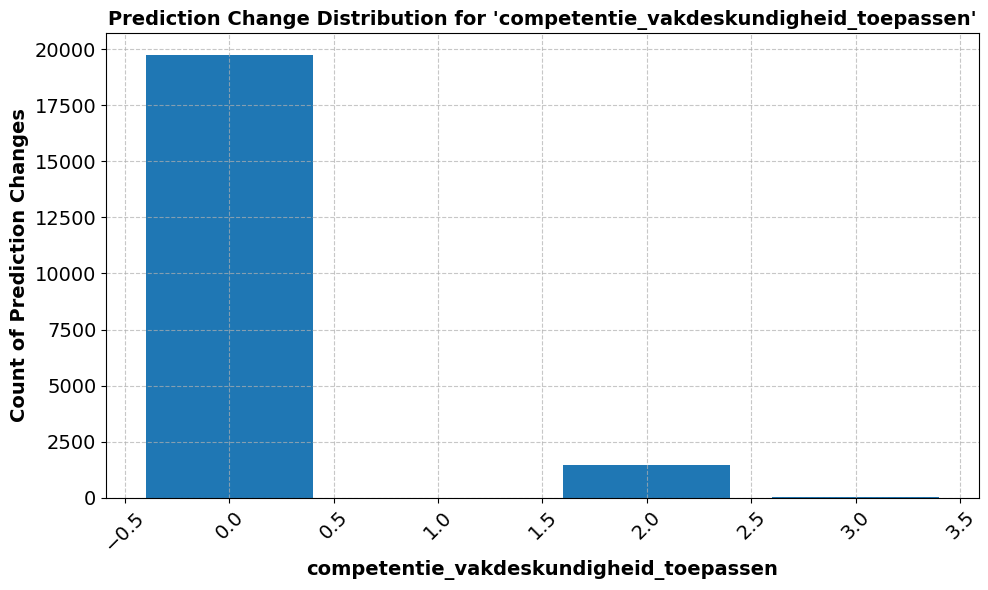

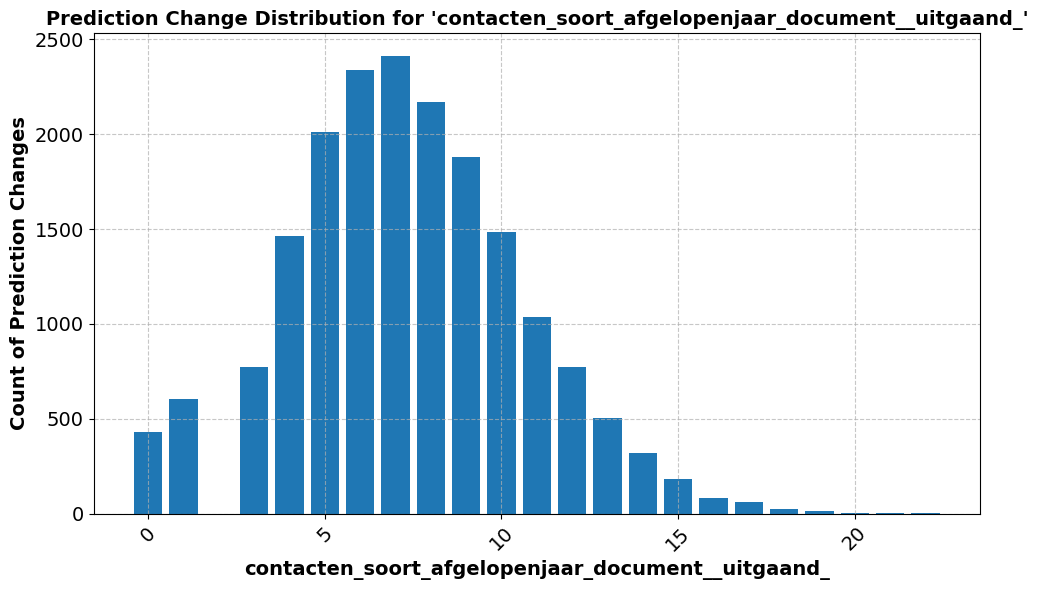

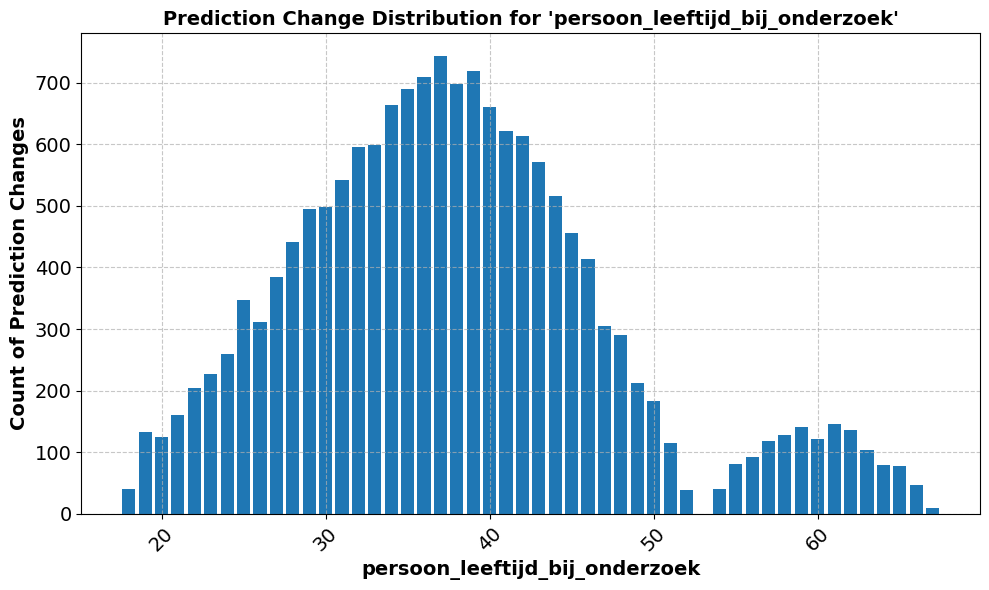

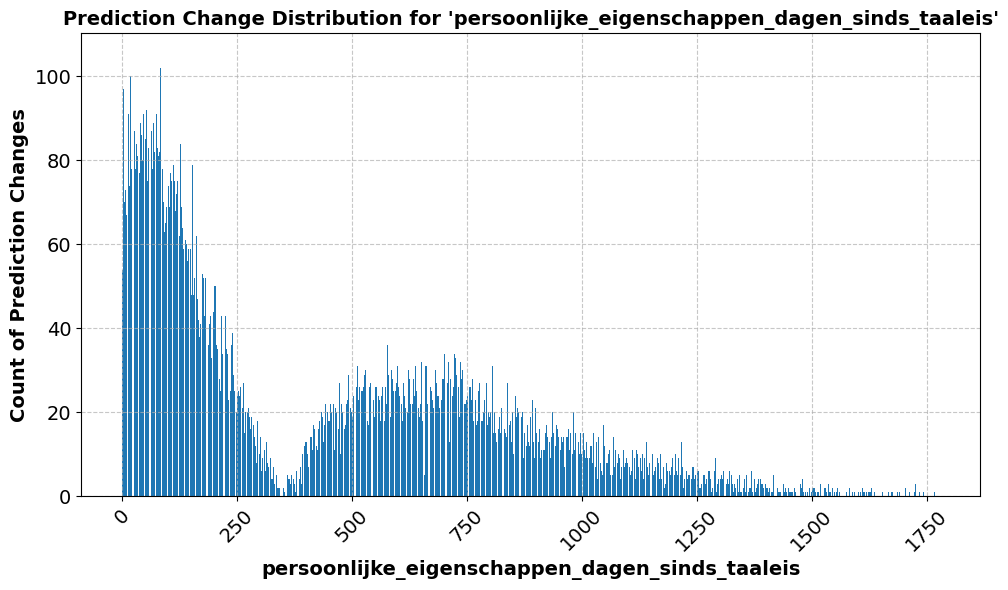

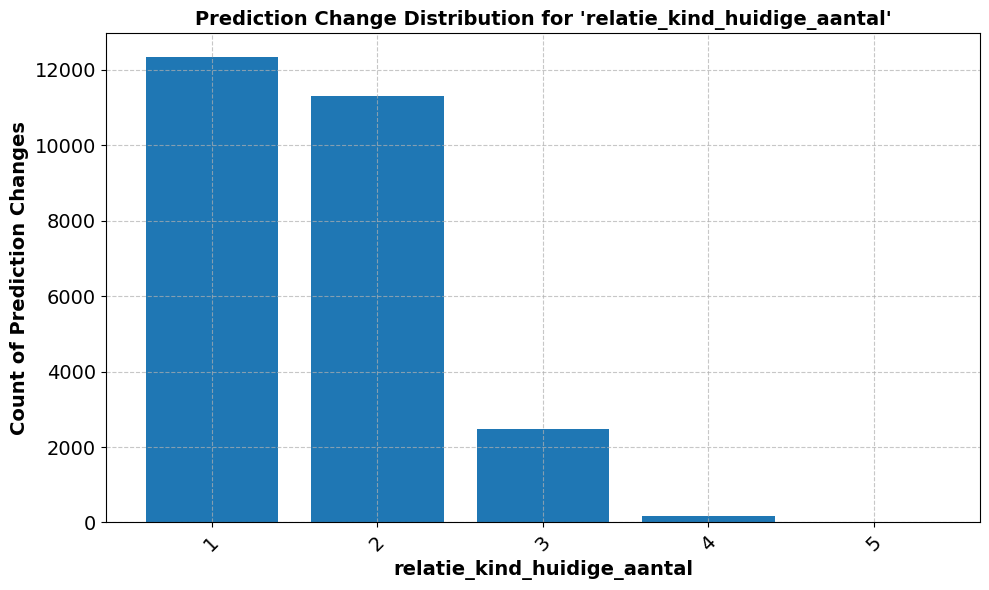

In [21]:
visualize_fairness_bar(violations)

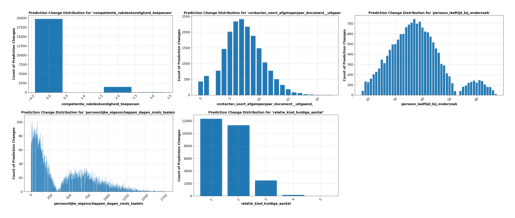

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

# Load images
images = [
    Image.open('../images/metatest_1.png'),
    Image.open('../images/metatest_2.png'),
    Image.open('../images/metatest_3.png'),
    Image.open('../images/metatest_4.png'),
    Image.open('../images/metatest_5.png'),
]

# Get individual image dimensions (assuming all images have the same size)
img_width, img_height = images[0].size

# Define combined image dimensions
rows = 2
cols = 3
combined_width = cols * img_width
combined_height = rows * img_height

while len(images) < rows * cols:
    images.append(Image.new('RGB', (img_width, img_height), (255, 255, 255))) 

# Create a new blank image for the combined result
combined_image = Image.new('RGB', (combined_width, combined_height))

# Paste images into the combined image
for idx, image in enumerate(images):
    row = idx // cols
    col = idx % cols
    x_offset = col * img_width
    y_offset = row * img_height
    combined_image.paste(image, (x_offset, y_offset))

# Display and save the combined image
plt.imshow(combined_image)
plt.axis('off')
combined_image.save('../images/combined_image.jpg', format='JPEG')
plt.show()
